##Initializations

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/MLPROJ')
# !ls

bowl		 dataset-10.pkl    MLProject3.ipynb  Robotiq2F85.py
bowl.zip	 dataset-1.pkl	   MLProject4.ipynb  robotiq_2f_85.zip
checkpoint	 dataset_samples   PickPlaceEnv.py   __temp__.mp4
chess_set	 image_path_v2	   __pycache__	     ur5e
dataset-100.pkl  llm_cache.pickle  robotiq_2f_85     ur5e.zip


In [10]:
import os
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip



# ViLD pretrained model weights.
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2 ./

%load_ext tensorboard

# openai.api_key = openai_api_key

# Show useful GPU info.
!nvidia-smi

# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-51gmeyk7JShEc1UN2lrz-JCmHIiu75y
To: /content/ur5e.zip
100% 2.94M/2.94M [00:00<00:00, 174MB/s]
unzip:  cannot find or open chess_set.zip, chess_set.zip.zip or chess_set.zip.ZIP.
Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/saved_model.pb...
Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/varia

  print(xla_bridge.get_backend().platform)



gpu


In [17]:
import gdown
import zipfile
dataset_file = 'chess_set.zip'
file_id = "1gI4XcspVa2VPnORiTng-Dh_zyxHnjdU3"
gdown.download(id=file_id, output=dataset_file, quiet=False)
with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall('.')

Downloading...
From: https://drive.google.com/uc?id=1gI4XcspVa2VPnORiTng-Dh_zyxHnjdU3
To: /content/chess_set.zip
100%|██████████| 1.06M/1.06M [00:00<00:00, 135MB/s]


In [1]:
from IPython.display import clear_output as clc

In [2]:
!pip install ftfy regex tqdm fvcore
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
!pip install openai
!pip install easydict
!pip install imageio-ffmpeg
!pip install tiktoken
!pip install python-chess
!pip install -q ultralytics
!pip install -q opencv-python-headless
clc()

In [3]:
import collections
import datetime
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import clear_output as clc
import os
import re # For parsing commands
import random  # For mock LLM responses


clc()

## Available Pick and Place

In [4]:
PICK_TARGETS = {
    # # White pieces
    "white King": "e1",
    "white Queen": "d1",
    "white Rook 1": "a1",
    # "white Rook 2": "h1",
    # "white Knight 1": "b8",
    # "white Knight 2": "g1",
    "white Bishop 1": "c1",
    # "white Bishop 2": "f1",
    "white Pawn 1": "a2",


    # # Black pieces
    "black King": "e8",
    "black Queen": "d8",
    "black Rook 1": "a8",
    # "black Rook 2": "h8",
    # "black Knight 1": "b4",
    # "black Knight 2": "g8",
    "black Bishop 1": "c8",
    # "black Bishop 2": "f8",
    "black Pawn 1": "a7",
    # "black Pawn 2": "b7",
    # "black Pawn 3": "c7",
    # "black Pawn 4": "d7",
    # "black Pawn 5": "e7",
    # "black Pawn 6": "f7",
    # "black Pawn 7": "g7",
    # "black Pawn 8": "h7",
    }



COLORS = {
    "blue":   (78/255,  121/255, 167/255, 255/255),
    "red":    (255/255,  87/255,  89/255, 255/255),
    "green":  (89/255,  169/255,  79/255, 255/255),
    "yellow": (237/255, 201/255,  72/255, 255/255),
    "orange": (242/255, 142/255,  43/255, 255/255),
    "white": (255/255, 255/255, 255/255, 255/255),
    "black": (40/255, 26/255, 13/255, 255/255)
}

square_size = 0.085
target_z = 0.02
board_size=8
z_height=0.01

start_x = -0.35 + 0.05 + (square_size / 2)
start_y = -0.08 - 0.05 - (square_size / 2)

PLACE_TARGETS = {}

# Board squares
for row in range(8):  # rows 0 to 7 represent ranks 1 to 8
    for col in range(8):  # columns 0 to 7 represent files a to h
        square_name = chr(ord('h') - col) + str(row + 1)
        PLACE_TARGETS[square_name] = [
            start_x + col * square_size,
            start_y - row * square_size,
            target_z
        ]





PIXEL_SIZE = 0.003
BOUNDS = np.float32([[-0.3975+0.075, 0.3225+0.075], [-0.9925+0.2, -0.2725+0.2], [0, 0.12]])  # X Y Z




## ROBOT environment and gripper

In [6]:
class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = "robotiq_2f_85/robotiq_2f_85.urdf"
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool: qui mette un JOINT_FIXED tra robot e gripper
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  # Check_grasp e Grasp_width assist in determining the effectiveness of a grip
  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist
  # Check Proximity with other surfaces using ray cast
  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

  def stop(self):
        self.running = False
        self.constraints_thread.join()

In [7]:
class PickPlaceEnv():
  # Environment Initialization: utilizza PyBullet
  def __init__(self):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

  # Reset dell'environment
  def reset(self, config):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Create the chess board
    self.create_chess_board()

    # Load objects according to config.
    self.config = config
    self.obj_name_to_id = {}

    # Define how pieces should be placed on the board
    # Using the piece naming format from your config
    piece_placements={}


    # Get list of pieces to place from config
    obj_names = list(self.config["pick"]) if "pick" in self.config else []
    obj_xyz = np.zeros((0, 3))
    # Process each piece
    for obj_name in obj_names:
        # Get piece type and color
        parts = obj_name.split()
        if len(parts) < 2:
            continue

        color = parts[0]

        piece_type = parts[1]

        while True:
          rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
          rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
          rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
          if len(obj_xyz) == 0:
            obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
            break
          else:
            nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
            if nn_dist > 0.08:
              obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
              break

        object_color = COLORS[color]
        object_position = rand_xyz.squeeze()


        # Load appropriate object based on type
        if piece_type == "block":
            object_position[2] = 0
            object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
            object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
            object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
        elif piece_type == "bowl":
            object_position[2] = 0
            object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
        elif piece_type == "cylinder":
            radius = 0.02
            height = 0.05
            object_shape = pybullet.createCollisionShape(pybullet.GEOM_CYLINDER, radius=radius, height=height)
            object_visual = pybullet.createVisualShape(pybullet.GEOM_CYLINDER, radius=radius, length=height)
            object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
            object_position[2] = height / 2
        elif piece_type == "Queen":

          object_id = pybullet.loadURDF("chess_set/Queen_white/Queen_white.urdf", object_position)
        elif piece_type == "Rook":
          object_id = pybullet.loadURDF("chess_set/Castle_white/Castle_white.urdf", object_position)
        elif piece_type == "Knight":
          rotation_quat = pybullet.getQuaternionFromEuler([0, 0, np.pi / 2])
          object_id = pybullet.loadURDF("chess_set/Rook_white/Rook_white.urdf", object_position,rotation_quat)
        elif piece_type == "King":
          object_id = pybullet.loadURDF("chess_set/king_white/king_white.urdf", object_position)
        elif piece_type == "Pawn":
          object_id = pybullet.loadURDF("chess_set/pawn_black/pawn_black.urdf", object_position)
        elif piece_type == "Bishop":
          object_id = pybullet.loadURDF("chess_set/Bishop_white/Bishop_white.urdf", object_position)

        # Store the object ID
        if object_id is not None:
            pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
            self.obj_name_to_id[obj_name] = object_id

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
        pybullet.stepSimulation()
    return self.get_observation()


  ################################# chess board ###############################
  def create_chess_board(self):
    print('making the chess board')

    # Create the chess board
    for row in range(board_size):
        for col in range(board_size):
            # Determine position
            pos_x = start_x + col * square_size
            pos_y = start_y - row * square_size
            position = [pos_x, pos_y, z_height]

            # Determine color (alternating pattern)
            is_white = (row + col) % 2 == 0
            color = [0.91, 0.76, 0.65, 1] if is_white else [0.36, 0.25, 0.20, 1]

            # Create block
            half_extents = [square_size/2, square_size/2, 0.01]  # Flatter for chess squares
            object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=half_extents)
            object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX,
                                                      halfExtents=half_extents,
                                                      rgbaColor=color)
            pybullet.createMultiBody(0, object_shape, object_visual, basePosition=position)
  # Joint control
  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)

  # End-effector positioning
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  # Step è la funzione che gestisce tutta la primitiva di pick&place
  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_xyz, place_xyz = action["pick"].copy(), action["place"].copy()

    # Set fixed primitive z-heights.
    hover_xyz = pick_xyz.copy() + np.float32([0, 0, 0.2])
    pick_xyz[2] = 0.02
    place_xyz[2] = 0.12

    # Move to object.
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.02):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    # Render current image at 8 FPS.
    if self.sim_step % 60 == 0:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    image_size = (720, 720)
    intrinsics = (600., 0, 360., 0, 600., 360., 0, 0, 1)
    color, _, _, _, _ = self.render_image(image_size, intrinsics)
    return color

  def get_camera_image_top(self,
                           image_size=(720, 720),
                           intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                           position=(0.05, -0.45, 4),
                           orientation=(0, np.pi, -np.pi / 2),
                           zrange=(0.01, 1.),
                           set_alpha=True):
    set_alpha and self.set_alpha_transparency(0)
    color, _, _, _, _ = self.render_image_top(image_size,
                                             intrinsics,
                                             position,
                                             orientation,
                                             zrange)
    set_alpha and self.set_alpha_transparency(1)
    return color

  def get_reward(self):
    return 0

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap
    observation["pick"] = list(self.config["pick"])
    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -1.05, 0.6)
    orientation = (np.pi / 5 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def render_image_top(self,
                       image_size=(720, 720),
                       intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                       position=(0.2, -0.45, 3.5),
                       orientation=(0, np.pi, -np.pi / 2),
                       zrange=(0.01, 1.)):

    # Camera parameters.
    orientation = pybullet.getQuaternionFromEuler(orientation)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def world_to_pixel(self, world_point, height, width):
    # Get camera parameters
    position = getattr(self, 'camera_position', (0.05, -0.45, 4))
    orientation = getattr(self, 'camera_orientation', (0, np.pi, -np.pi / 2))
    intrinsics = getattr(self, 'camera_intrinsics', (3500., 0, 360., 0, 3500., 360., 0, 0, 1))

    # Scale intrinsics to current image size (assuming original was 720x720)
    ref_width = 720
    ref_height = 720
    fx, _, cx, _, fy, cy, _, _, _ = intrinsics
    fx *= width / ref_width
    fy *= height / ref_height
    cx *= width / ref_width
    cy *= height / ref_height
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    # Transform world point to camera frame
    orientation_quat = pybullet.getQuaternionFromEuler(orientation)
    rotation = np.array(pybullet.getMatrixFromQuaternion(orientation_quat)).reshape(3, 3)
    point_relative = np.array(world_point) - np.array(position)
    point_camera = rotation.T @ point_relative

    if point_camera[2] <= 0:
      return (None, None, False)

    # Project to image
    point_normalized = point_camera / point_camera[2]
    pixel_homogeneous = K @ point_normalized
    u = int(round(pixel_homogeneous[0]))
    v = int(round(pixel_homogeneous[1]))
    return (u, v)


  def pixel_to_world(self, pixel_u, pixel_v, depth_at_pixel, height, width):

    if depth_at_pixel <= 1e-5: # Depth must be positive and non-trivial
        # print("Warning: depth_at_pixel must be positive.")
        return None

    # Get camera parameters from class attributes (or their defaults)
    # These must match the parameters used for rendering the image/depth map
    cam_position_world = np.array(getattr(self, 'camera_position', (0.05, -0.45, 4.0)))
    cam_orientation_euler_world = getattr(self, 'camera_orientation', (0, np.pi, -np.pi / 2))
    base_intrinsics_params = getattr(self, 'camera_intrinsics', (3500., 0, 360., 0, 3500., 360., 0, 0, 1))

    # Reference dimensions for the base_intrinsics_params
    ref_width = 720
    ref_height = 720

    fx_base, _, cx_base, _, fy_base, cy_base, _, _, _ = base_intrinsics_params

    # Scale intrinsics to the current image dimensions (height, width)
    fx = fx_base * (width / ref_width)
    fy = fy_base * (height / ref_height)
    cx = cx_base * (width / ref_width)
    cy = cy_base * (height / ref_height)

    if fx == 0 or fy == 0:
        # print("Warning: Scaled focal length fx or fy is zero. Cannot unproject.")
        return None

    # Convert pixel coordinates to normalized image coordinates (on a plane where z_camera=1)
    # x_normalized = (u - cx) / fx
    # y_normalized = (v - cy) / fy
    x_normalized = (pixel_u - cx) / fx
    y_normalized = (pixel_v - cy) / fy

    # Create 3D point in camera coordinates
    # (x_cam, y_cam, z_cam)
    # z_cam is the provided depth_at_pixel
    x_camera_frame = x_normalized * depth_at_pixel
    y_camera_frame = y_normalized * depth_at_pixel
    z_camera_frame = depth_at_pixel

    point_camera_frame = np.array([x_camera_frame, y_camera_frame, z_camera_frame])

    # Transform point from camera frame to world frame
    # P_world = R_cam_to_world @ P_camera_frame + T_cam_in_world
    # R_cam_to_world is the camera's orientation matrix in the world.
    # T_cam_in_world is the camera's position in the world.

    cam_orientation_quat_world = pybullet.getQuaternionFromEuler(cam_orientation_euler_world)
    R_cam_to_world = np.array(pybullet.getMatrixFromQuaternion(cam_orientation_quat_world)).reshape(3, 3)

    # Apply rotation then translation
    world_point = R_cam_to_world @ point_camera_frame + cam_position_world

    return world_point

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            "constant", constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap



In [8]:
!cd chess_set/

/bin/bash: line 1: cd: chess_set/: No such file or directory


making the chess board


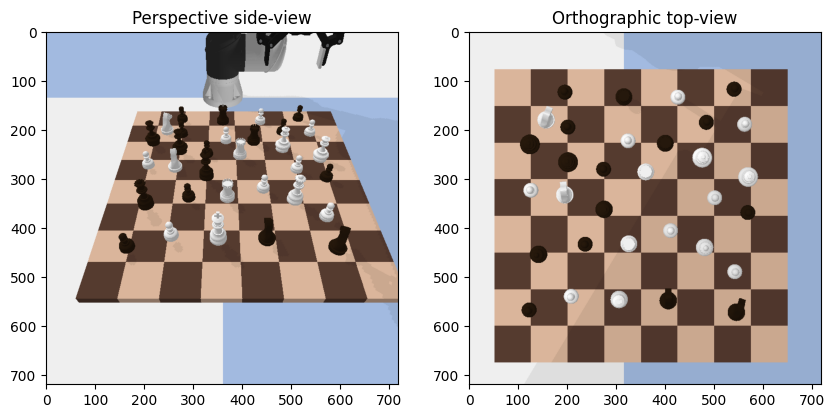

In [18]:
config = {
    'pick': [
        "white King",
        "white Queen",
        "white Rook 1",
        "white Rook 2",
        "white Bishop 1",
        "white Bishop 2",
        "white Knight 1",
        "white Knight 2",
        "white Pawn 1",
        "white Pawn 2",
        "white Pawn 3",
        "white Pawn 4",
        "white Pawn 5",
        "white Pawn 6",
        "white Pawn 7",
        "white Pawn 8",
        "black King",
        "black Queen",
        "black Rook 1",
        "black Rook 2",
        "black Bishop 1",
        "black Bishop 2",
        "black Knight 1",
        "black Knight 2",
        "black Pawn 1",
        "black Pawn 2",
        "black Pawn 3",
        "black Pawn 4",
        "black Pawn 5",
        "black Pawn 6",
        "black Pawn 7",
        "black Pawn 8"
    ]
}





np.random.seed(40)
env = PickPlaceEnv()
obs = env.reset(config)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)



plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)

plt.show()




## Command with Text

In [19]:
class ScriptedPolicy():

  def __init__(self, env):
    self.env = env

  def step(self, text, obs):
    print(f'Input: {text}')

    # Parse pick and place targets.
    pick_text, place_text = text.split('and')
    pick_target, place_target = None, None
    for name in PICK_TARGETS.keys():
      if name in pick_text:
        pick_target = name
        break
    for name in PLACE_TARGETS.keys():
      if name in place_text:
        place_target = name
        break

    # Admissable targets only.
    assert pick_target is not None
    assert place_target is not None

    pick_id = self.env.obj_name_to_id[pick_target]
    pick_pose = pybullet.getBasePositionAndOrientation(pick_id)
    pick_position = np.float32(pick_pose[0])

    if place_target in self.env.obj_name_to_id:
      place_id = self.env.obj_name_to_id[place_target]
      place_pose = pybullet.getBasePositionAndOrientation(place_id)
      place_position = np.float32(place_pose[0])
    else:
      place_position = np.float32(PLACE_TARGETS[place_target])

    # Add some noise to pick and place positions.
    # pick_position[:2] += np.random.normal(scale=0.01)
    # place_position[:2] += np.random.normal(scale=0.01)

    act = {'pick': pick_position, 'place': place_position}

    return act


## Cliport
config with one piece of each type

making the chess board


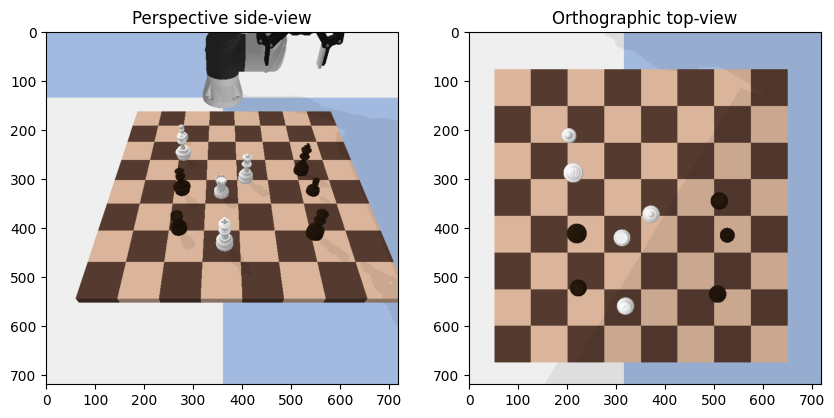

In [20]:
config = {
    'pick': [
        "white King",
        "white Queen",
        "white Rook 1",
        "white Bishop 1",
        "white Pawn 1",


        "black King",
        "black Queen",
        "black Rook 1",
        "black Bishop 1",
        "black Pawn 1",



    ]
}




np.random.seed(2)
env = PickPlaceEnv()
obs = env.reset(config)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)
plt.show()


# Generating The Data
will be saved in dataset_samples/sample-{i}.pkl

In [21]:
Generate_data = False
np.random.seed(10)
env = PickPlaceEnv()
img_height=224
if Generate_data:
    dataset_size = 10000  # Number of samples to generate
    save_dir = 'dataset_samples'
    os.makedirs(save_dir, exist_ok=True)

    all_samples = []  # Accumulate all samples here
    policy = ScriptedPolicy(env)
    data_idx = 0

    while data_idx < dataset_size:
        np.random.seed(data_idx)
        num_pick, num_place = 10, 10

        pick_items = list(PICK_TARGETS.keys())
        pick_items = np.random.choice(pick_items, size=num_pick, replace=False)
        place_items = list(PLACE_TARGETS.keys())
        place_items = np.random.choice(place_items, size=num_place, replace=False)
        config = {'pick': pick_items, 'place': place_items}

        obs = env.reset(config)

        prompts = [
            f'Pick the {pick_items[i]} and place it on the {place_items[i]}.'
            for i in range(len(pick_items))
        ]

        for prompt in prompts:
            act = policy.step(prompt, obs)
            img = env.get_camera_image_top()
            img = cv2.resize(img, (img_height, img_height))
            sample = {
                'text': prompt,
                'image': img,
                'pick_yx': env.world_to_pixel(act['pick'], img_height, img_height),
                'place_yx': env.world_to_pixel(act['place'], img_height, img_height)
            }

            all_samples.append(sample)
            print(f'Collected sample {data_idx}')
            data_idx += 1

            if data_idx >= dataset_size:
                break

    # Save all samples into one file
    single_file_path = os.path.join(save_dir, 'combined_dataset.pkl')
    with open(single_file_path, 'wb') as f:
        pickle.dump(all_samples, f)

    print(f'Saved all {dataset_size} samples to {single_file_path}')

Cheking the data

Downloading...
From (original): https://drive.google.com/uc?id=12svi8MWJlxktMdvW9IDD-xZ_TkwYlF1B
From (redirected): https://drive.google.com/uc?id=12svi8MWJlxktMdvW9IDD-xZ_TkwYlF1B&confirm=t&uuid=a2e2a168-7498-40ea-8d5f-e93ba80322b2
To: /content/dataset_samples/combined_dataset.pkl
100%|██████████| 1.21G/1.21G [00:11<00:00, 103MB/s]


Pick coordinates (yx): (141, 87)
Place coordinates (yx): (141, 144)


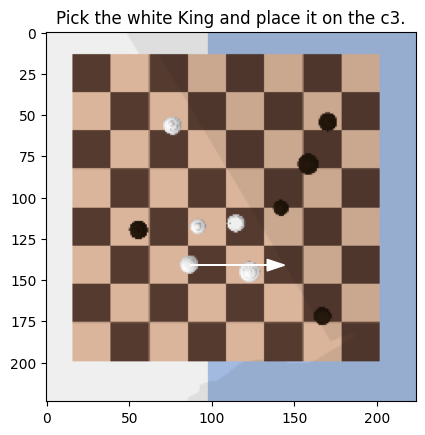

In [22]:
dataset_file = 'dataset_samples/combined_dataset.pkl'

import os
import gdown
os.makedirs("dataset_samples", exist_ok=True)
file_id = "12svi8MWJlxktMdvW9IDD-xZ_TkwYlF1B"
gdown.download(id=file_id, output=dataset_file, quiet=False)



try:
    all_samples
except NameError:
    with open(dataset_file, 'rb') as f:
        all_samples = pickle.load(f)

# Select sample index
sample_idx = 300
sample = all_samples[sample_idx]

img = sample['image']
pick_yx = sample['pick_yx']
place_yx = sample['place_yx']
text = sample['text']

# Checking pick and place coordinates
print(f'Pick coordinates (yx): {pick_yx}')
print(f'Place coordinates (yx): {place_yx}')

# Visualize pick and place coordinates on the image
plt.title(text)
img = img.transpose(1, 0, 2)
plt.imshow(img)

# Draw an arrow from pick to place
plt.arrow(pick_yx[1], pick_yx[0],
          place_yx[1] - pick_yx[1],
          place_yx[0] - pick_yx[0],
          color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)

plt.show()

Network Architecture

In [23]:

class ResNetBlock(nn.Module):
  # The ResNetBlock class represents a single block in a ResNet (Residual Network) architecture.
  """ResNet pre-Activation block. https://arxiv.org/pdf/1603.05027.pdf"""
  features: int
  stride: int = 1

  def setup(self):
    self.conv0 = nn.Conv(self.features // 4, (1, 1), (self.stride, self.stride))
    self.conv1 = nn.Conv(self.features // 4, (3, 3))
    self.conv2 = nn.Conv(self.features, (1, 1))
    self.conv3 = nn.Conv(self.features, (1, 1), (self.stride, self.stride))

  def __call__(self, x):
    y = self.conv0(nn.relu(x))
    y = self.conv1(nn.relu(y))
    y = self.conv2(nn.relu(y))
    if x.shape != y.shape:
      x = self.conv3(nn.relu(x))
    return x + y


class UpSample(nn.Module):
  """Simple 2D 2x bilinear upsample."""

  def __call__(self, x):
    B, H, W, C = x.shape
    new_shape = (B, H * 2, W * 2, C)
    return jax.image.resize(x, new_shape, 'bilinear')


class ResNet(nn.Module):
  """Hourglass 53-layer ResNet with 8-stride."""
  out_dim: int

  def setup(self):
    self.dense0 = nn.Dense(8)

    self.conv0 = nn.Conv(64, (3, 3), (1, 1))
    self.block0 = ResNetBlock(64)
    self.block1 = ResNetBlock(64)
    self.block2 = ResNetBlock(128, stride=2)
    self.block3 = ResNetBlock(128)
    self.block4 = ResNetBlock(256, stride=2)
    self.block5 = ResNetBlock(256)
    self.block6 = ResNetBlock(512, stride=2)
    self.block7 = ResNetBlock(512)

    self.block8 = ResNetBlock(256)
    self.block9 = ResNetBlock(256)
    self.upsample0 = UpSample()
    self.block10 = ResNetBlock(128)
    self.block11 = ResNetBlock(128)
    self.upsample1 = UpSample()
    self.block12 = ResNetBlock(64)
    self.block13 = ResNetBlock(64)
    self.upsample2 = UpSample()
    self.block14 = ResNetBlock(16)
    self.block15 = ResNetBlock(16)
    self.conv1 = nn.Conv(self.out_dim, (3, 3), (1, 1))

  def __call__(self, x, text):

    # # Project and concatenate CLIP features (early fusion).
    # text = self.dense0(text)
    # text = jnp.expand_dims(text, axis=(1, 2))
    # text = jnp.broadcast_to(text, x.shape[:3] + (8,))
    # x = jnp.concatenate((x, text), axis=-1)

    x = self.conv0(x)
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)

    # Concatenate CLIP features (mid-fusion).
    text = jnp.expand_dims(text, axis=(1, 2))
    text = jnp.broadcast_to(text, x.shape)
    x = jnp.concatenate((x, text), axis=-1)

    x = self.block8(x)
    x = self.block9(x)
    x = self.upsample0(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.upsample1(x)
    x = self.block12(x)
    x = self.block13(x)
    x = self.upsample2(x)
    x = self.block14(x)
    x = self.block15(x)
    x = self.conv1(x)
    return x


class TransporterNets(nn.Module):
  """TransporterNet with 3 ResNets (translation only)."""

  def setup(self):
    # Picking affordances.
    self.pick_net = ResNet(1)

    # Pick-conditioned placing affordances.
    self.q_net = ResNet(3)  # Query (crop around pick location).
    self.k_net = ResNet(3)  # Key (place features).
    self.crop_size = 64
    self.crop_conv = nn.Conv(features=1, kernel_size=(self.crop_size, self.crop_size), use_bias=False, dtype=jnp.float32, padding='SAME')

  def __call__(self, x, text, p=None, train=True):
    print(x.shape)
    B, H, W, C = x.shape
    pick_out = self.pick_net(x, text)  # (B, H, W, 1)

    # Get key features.
    k = self.k_net(x, text)

    # Add 0-padding before cropping.
    h = self.crop_size // 2
    x_crop = jnp.pad(x, [(0, 0), (h, h), (h, h), (0, 0)], 'maximum')

    # Get query features and convolve them over key features.
    place_out = jnp.zeros((0, H, W, 1), jnp.float32)
    for b in range(B):

      # Get coordinates at center of crop.
      if p is None:
        pick_out_b = pick_out[b, ...]  # (H, W, 1)
        pick_out_b = pick_out_b.flatten()  # (H * W,)
        amax_i = jnp.argmax(pick_out_b)
        v, u = jnp.unravel_index(amax_i, (H, W))
      else:
        v, u = p[b, :]

      # Get query crop.
      x_crop_b = jax.lax.dynamic_slice(x_crop, (b, v, u, 0), (1, self.crop_size, self.crop_size, x_crop.shape[3]))
      # x_crop_b = x_crop[b:b+1, v:(v + self.crop_size), u:(u + self.crop_size), ...]

      # Convolve q (query) across k (key).
      q = self.q_net(x_crop_b, text[b:b+1, :])  # (1, H, W, 3)
      q = jnp.transpose(q, (1, 2, 3, 0))  # (H, W, 3, 1)
      place_out_b = self.crop_conv.apply({'params': {'kernel': q}}, k[b:b+1, ...])  # (1, H, W, 1)
      scale = 1 / (self.crop_size * self.crop_size)  # For higher softmax temperatures.
      place_out_b *= scale
      place_out = jnp.concatenate((place_out, place_out_b), axis=0)

    return pick_out, place_out

#def n_params(params):
#    if isinstance(params, dict) or isinstance(params, flax.core.frozen_dict.FrozenDict):
#        return jnp.sum(jnp.int32([n_params(v) for v in params.values()]))
#    else:
#        return np.prod(params.shape)

def n_params(params):
  return jnp.sum(jnp.int32([n_params(v) if isinstance(v, dict) or isinstance(v, flax.core.frozen_dict.FrozenDict) else np.prod(v.shape) for v in params.values()]))



Loading parameters of a pretrained clip

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32",device)
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", clip_model.visual.input_resolution)
print("Context length:", clip_model.context_length)
print("Vocab size:", clip_model.vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Tokenizing the Text in our saved data

In [25]:

# Load all samples at once
try:
    all_samples
except NameError:
    with open(dataset_file, 'rb') as f:
        all_samples = pickle.load(f)

# Extract all text prompts
texts = [sample['text'] for sample in all_samples]

# Tokenize text prompts using CLIP
text_tokens = clip.tokenize(texts).to(device)

# Compute CLIP features in batches
data_text_feats = np.zeros((len(texts), 512), dtype=np.float32)
batch_size = 128
for start in tqdm(range(0, len(text_tokens), batch_size), desc="Encoding CLIP text features"):
    end = start + batch_size
    with torch.no_grad():
        batch_feats = clip_model.encode_text(text_tokens[start:end]).float()
        batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
        data_text_feats[start:end] = batch_feats.cpu().numpy().astype(np.float32)


Downloading...
From (original): https://drive.google.com/uc?id=12svi8MWJlxktMdvW9IDD-xZ_TkwYlF1B
From (redirected): https://drive.google.com/uc?id=12svi8MWJlxktMdvW9IDD-xZ_TkwYlF1B&confirm=t&uuid=dbbf7962-1a23-4108-ac84-7a7e03a092de
To: /content/dataset_samples/combined_dataset.pkl
100%|██████████| 1.21G/1.21G [00:07<00:00, 170MB/s] 
Encoding CLIP text features: 100%|██████████| 63/63 [00:06<00:00, 10.43it/s]


In [26]:
img_height=224
# Train with InfoNCE loss over pick and place positions.
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(params):
    batch_size = batch['img'].shape[0]
    pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'], batch['pick_yx'])

    # InfoNCE pick loss.
    pick_logits = pick_logits.reshape(batch_size, -1)
    pick_onehot = batch['pick_onehot'].reshape(batch_size, -1)
    pick_loss = jnp.mean(optax.softmax_cross_entropy(logits=pick_logits, labels=pick_onehot), axis=0)

    # InfoNCE place loss.
    place_logits = place_logits.reshape(batch_size, -1)
    place_onehot = batch['place_onehot'].reshape(batch_size, -1)
    place_loss = jnp.mean(optax.softmax_cross_entropy(logits=place_logits, labels=place_onehot), axis=0)

    loss = pick_loss + place_loss
    return loss, (pick_logits, place_logits)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grad = grad_fn(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss, grad, logits

@jax.jit
def eval_step(params, batch):
  pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'])
  return pick_logits, place_logits

# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, img_height), np.linspace(-1, 1, img_height), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [27]:
from orbax.checkpoint import PyTreeCheckpointer
from jax.sharding import SingleDeviceSharding
import jax
import os

In [28]:
print(jax.devices())
print(jax.default_backend())

[CudaDevice(id=0)]
gpu


### Train or load pretrained

will be saved in /checkpoint/checkpoint_{i}

** to load GPU should be enabled

In [31]:
# Import necessary libraries
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training import checkpoints
import os
from google.colab import drive
import gdown
import zipfile
import shutil

# Initialize model weights using dummy tensors.
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
init_text = jnp.ones((4, 512), jnp.float32)
init_pix = jnp.zeros((4, 2), np.int32)
init_params = TransporterNets().init(key, init_img, init_text, init_pix)['params']
print(f'Model parameters: {n_params(init_params):,}')
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(init_params)
dataset_size=8000
# Load checkpoint configuration
load_pretrained = True  # Set to True if you want to load a checkpoint
checkpoint_dir = os.path.abspath('checkpoint')
checkpointer = PyTreeCheckpointer()
device = jax.local_devices()[0]



def check_checkpoint_keys(ckpt_path):
    if os.path.exists(ckpt_path):
        state_dict = checkpoints.restore_checkpoint(ckpt_path, target=None)
        print("Keys in the checkpoint:", state_dict.keys())
    else:
        print("Checkpoint path does not exist:", ckpt_path)

if load_pretrained:
    checkpoint_zip = 'checkpoint_19000.zip'  # Different name for the zip file
    os.makedirs("checkpoint", exist_ok=True)

    # Remove existing checkpoint_19000 if it exists
    checkpoint_path = 'checkpoint/checkpoint_19000'
    if os.path.exists(checkpoint_path):
        if os.path.isdir(checkpoint_path):
            shutil.rmtree(checkpoint_path)
        else:
            os.remove(checkpoint_path)

    file_id = "1GF4RnW88iW6CmRkRfqbmZK0dv6g2XKX9"
    gdown.download(id=file_id, output=checkpoint_zip, quiet=False)

    with zipfile.ZipFile(checkpoint_zip, 'r') as zip_ref:
        zip_ref.extractall("checkpoint")

    ckpt_path = os.path.abspath(os.path.join(checkpoint_dir, 'checkpoint_19000'))
    # Restore checkpoint
    restored_state = checkpointer.restore(ckpt_path)
    init_params = restored_state['params']
    opt_state = restored_state['opt_state']

    print('Loaded default checkpoint:', ckpt_path)

else:
    print("Starting training from scratch as no checkpoint is loaded.")

    batch_size = 4

    @jax.jit
    def train_step(params, opt_state, batch):
        def loss_fn(params):
            pick_logits, place_logits = TransporterNets().apply(
                {'params': params},
                batch['img'],
                batch['text'],
                batch['pick_yx']
            )

            # Flatten logits and compute InfoNCE losses
            pick_loss = jnp.mean(optax.softmax_cross_entropy(
                logits=pick_logits.reshape(batch_size, -1),
                labels=batch['pick_onehot'].reshape(batch_size, -1)
            ))

            place_loss = jnp.mean(optax.softmax_cross_entropy(
                logits=place_logits.reshape(batch_size, -1),
                labels=batch['place_onehot'].reshape(batch_size, -1)
            ))

            return pick_loss + place_loss, (pick_logits, place_logits)

        (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, logits

    for train_iter in range(1, 20000):
        batch_indices = np.random.randint(0, dataset_size, size=batch_size)

        imgs, text_feats, pick_yx_list, place_yx_list = [], [], [], []
        for i in batch_indices:
          sample = all_samples[i]
          im = sample['image'].transpose(1, 0, 2)
          imgs.append(im / 255.0)
          text_feats.append(data_text_feats[i])  # This assumes precomputed CLIP features
          pick_yx_list.append(sample['pick_yx'])
          place_yx_list.append(sample['place_yx'])

        # Convert to arrays
        img = np.stack(imgs, axis=0)

        text_feat = np.stack(text_feats, axis=0)
        pick_yx = np.array(pick_yx_list, dtype=np.int32)
        place_yx = np.array(place_yx_list, dtype=np.int32)

        # Add coordinate channels
        img = np.concatenate((img, np.broadcast_to(coords[None, ...], (batch_size,) + coords.shape)), axis=3)

        # Initialize one-hot maps
        pick_onehot = np.zeros((batch_size, img_height, img_height), dtype=np.float32)
        place_onehot = np.zeros((batch_size, img_height, img_height), dtype=np.float32)

        for i in range(batch_size):
            py, px = pick_yx[i]
            qy, qx = place_yx[i]

            # One-hot encode
            pick_onehot[i, py, px] = 1
            place_onehot[i, qy, qx] = 1

            # Data augmentation: roll (wrap) the image and labels
            roll_y, roll_x = np.random.randint(-img_height/2, img_height/2, size=2)
            img[i] = np.roll(img[i], shift=(roll_y, roll_x), axis=(0, 1))
            pick_onehot[i] = np.roll(pick_onehot[i], shift=(roll_y, roll_x), axis=(0, 1))
            place_onehot[i] = np.roll(place_onehot[i], shift=(roll_y, roll_x), axis=(0, 1))
            pick_yx[i] += np.array([roll_y, roll_x])

        # Prepare batch
        batch = {
            'img': jnp.float32(img),
            'text': jnp.float32(text_feat),
            'pick_yx': jnp.int32(pick_yx),
            'pick_onehot': jnp.float32(pick_onehot),
            'place_onehot': jnp.float32(place_onehot),
            'rng': jax.random.split(rng)[0]
        }

        # Train step
        init_params, opt_state, loss, _ = train_step(init_params, opt_state, batch)

        # Log loss
        if train_iter % np.power(10, min(4, np.floor(np.log10(train_iter)))) == 0:
            print(f'Train Step: {train_iter} | Loss: {loss:.6f}')

        # Save checkpoint
        if train_iter % 1000 == 0:
            checkpoints.save_checkpoint(
                checkpoint_dir,
                {'params': init_params, 'opt_state': opt_state},
                train_iter,
                keep=100000,
                overwrite=True
            )


(4, 224, 224, 5)
Model parameters: 4,259,095


Downloading...
From (original): https://drive.google.com/uc?id=1GF4RnW88iW6CmRkRfqbmZK0dv6g2XKX9
From (redirected): https://drive.google.com/uc?id=1GF4RnW88iW6CmRkRfqbmZK0dv6g2XKX9&confirm=t&uuid=d52e986f-3237-4218-9649-2964f47368af
To: /content/checkpoint_19000.zip
100%|██████████| 46.4M/46.4M [00:00<00:00, 211MB/s]
  warnings.warn(



Loaded default checkpoint: /content/checkpoint/checkpoint_19000


Test the model

making the chess board
(1, 224, 224, 5)
[130 134]
Pick position (yx): [130 134]
Pick position (xyz): [    0.13082    -0.38388         0.1]
Place position (yx): [165 144]
Place position (xyz): [    0.16755    -0.25531         0.1]


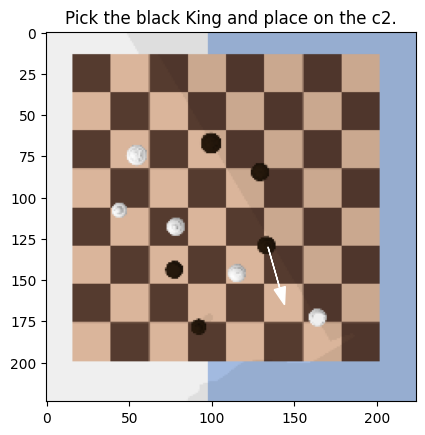

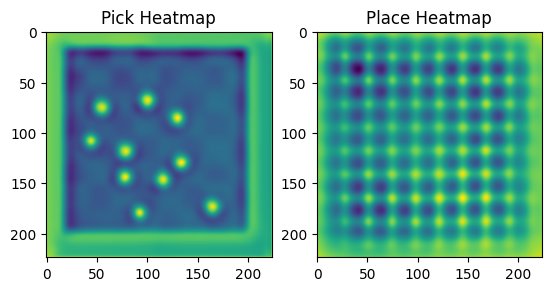

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


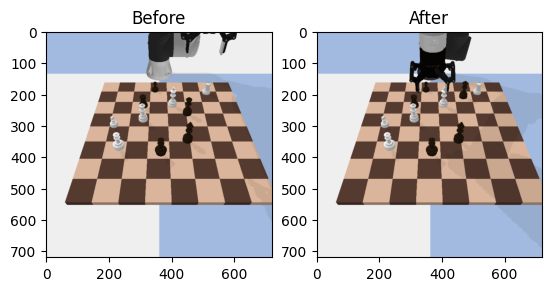

In [32]:

user_input = 'Pick the black King and place on the c2.' # Prompt

def eval_step(params, batch):
    pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'])
    return pick_logits, place_logits

def run_cliport(obs, text, params):
    before = env.get_camera_image()
    prev_obs = env.get_camera_image_top()
    prev_obs = cv2.resize(prev_obs, (224, 224))
    prev_obs=prev_obs.transpose(1, 0, 2)
    # Tokenize text and get CLIP features.
    text_tokens = clip.tokenize(text).cuda()
    with torch.no_grad():
        text_feats = clip_model.encode_text(text_tokens).float()
    text_feats /= text_feats.norm(dim=-1, keepdim=True)
    text_feats = np.float32(text_feats.cpu())

    # Normalize image and add batch dimension.
    img = env.get_camera_image_top()
    img=img.transpose(1, 0, 2)
    img = cv2.resize(img, (224, 224))

    img = img[None, ...] / 255
    img = np.concatenate((img, coords[None, ...]), axis=3)


    batch = {'img': jnp.float32(img), 'text': jnp.float32(text_feats)}

    # Evaluate model to get pick and place heatmaps.
    pick_map, place_map = eval_step(params, batch)
    pick_map, place_map = np.float32(pick_map), np.float32(place_map)

    # Get pick position.
    pick_max = np.argmax(np.float32(pick_map)).squeeze()
    pick_yx = (pick_max // 224, pick_max % 224)
    pick_yx = np.clip(pick_yx, 20, 204)
    print(pick_yx)
    pick_xyz = env.pixel_to_world(pick_yx[0],pick_yx[1],4,224,224)
    pick_xyz[2]=0.1
    print(f"Pick position (yx): {pick_yx}")  # Debug print
    print(f"Pick position (xyz): {pick_xyz}")  # Debug print



    place_max = np.argmax(np.float32(place_map)).squeeze()
    place_yx = (place_max // 224, place_max % 224)
    place_yx = np.clip(place_yx, 20, 204)
    place_xyz = env.pixel_to_world(place_yx[0],place_yx[1],4,224,224)
    place_xyz[2]=0.1
    print(f"Place position (yx): {place_yx}")  # Debug print
    print(f"Place position (xyz): {place_xyz}")  # Debug print

    # Step environment.
    act = {'pick': pick_xyz, 'place': place_xyz}
    obs, _, _, _ = env.step(act)

    # Show pick and place action.
    plt.title(text)
    plt.imshow(prev_obs)
    plt.arrow(pick_yx[1], pick_yx[0], place_yx[1]-pick_yx[1], place_yx[0]-pick_yx[0], color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
    plt.show()

    # Show debug plots.
    plt.subplot(1, 2, 1)
    plt.title('Pick Heatmap')
    plt.imshow(pick_map.reshape(224, 224))
    plt.subplot(1, 2, 2)
    plt.title('Place Heatmap')
    plt.imshow(place_map.reshape(224, 224))
    plt.show()

    # Show video of environment rollout.
    debug_clip = ImageSequenceClip(env.cache_video, fps=25)
    display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
    env.cache_video = []

    # Show camera image after pick and place.
    plt.subplot(1, 2, 1)
    plt.title('Before')
    plt.imshow(before)
    plt.subplot(1, 2, 2)
    plt.title('After')
    after = env.get_camera_image()
    plt.imshow(after)
    plt.show()

    return obs

# Example usage
np.random.seed(3)
env = PickPlaceEnv()
obs = env.reset(config)
obs = run_cliport(obs, user_input, init_params)